# HSGP by levels of a categorical covariate

Here is a [nice tutorial](https://bambinos.github.io/bambi/notebooks/hsgp_1d.html#hsgp-by-levels-of-a-categorical-covariate) on fitting a model with a HSGP contribution by levels of a categorical variable using Bambi.

This notebook aims to accomplish the same thing in PyMC so that HSGP's by categorical covariates can be incorporating into PyMC models.

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import arviz as az
import bambi as bmb
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load data

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/bambinos/bambi/main/tests/data/gam_data.csv")
data["fac"] = pd.Categorical(data["fac"])
data.head()[["x2", "y", "fac"]]

,x2,y,fac
0,0.497183,3.085274,3
1,0.196003,-2.250410,2
2,0.958474,0.070548,3
3,0.972759,-0.230454,1
4,0.755836,2.173497,2


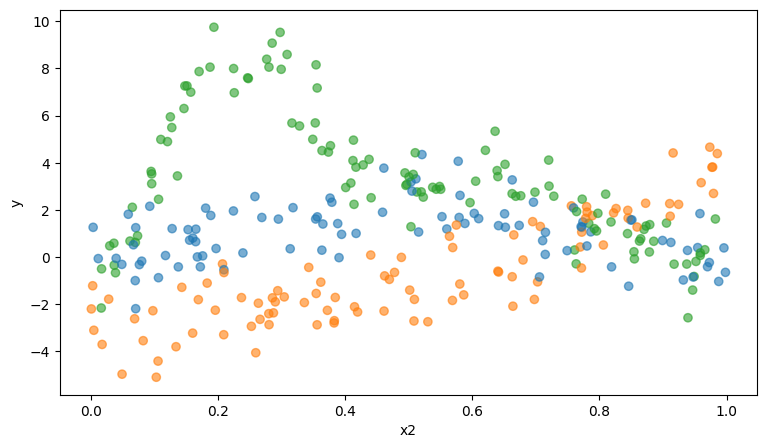

In [3]:
fig, ax = plt.subplots(figsize=(9, 5))
colors = [f"C{i}" for i in pd.Categorical(data["fac"]).codes]
ax.scatter(data["x2"], data["y"], color=colors, alpha=0.6)
ax.set(xlabel="x2", ylabel="y");

# Model

In [4]:
# Prepare the data
fac = sorted(data['fac'].unique())

# Create coordinate reference
coords = {
    'fac': fac,
    'obs_id': np.arange(len(data))
}

# Create mapping dictionaries
fac_lookup = {fac: i for i, fac in enumerate(fac)}

In [5]:
with pm.Model(coords=coords) as model:
    
    # Data containers
    fac_idx = pm.Data("fac_idx", [fac_lookup[i] for i in data['fac']])
    x2 = pm.Data("x2", data['x2'].values)
    y = pm.Data("y", data['y'].values)
    
    # HSGP priors
    length_scale = pm.Exponential("ell", lam=3, dims='fac')
    amplitude = pm.HalfCauchy('amplitude', 10, dims='fac')
    
    # Instantiate category specific HSGPs
    f_s = []
    for i in range(len(fac)):
        cov = (amplitude[i]**2) * pm.gp.cov.ExpQuad(1, ls=length_scale[i])
        gp = pm.gp.HSGP(m=[12], c=1.5, cov_func=cov)
        f = gp.prior(f"HSGP_{fac[i]}", X=x2[:, None])
        f_s.append(f)
        
    # Combine category-specific effects using stack and advanced indexing
    stacked_effects = pt.stack(f_s)  # Shape: (n_procedures, n_observations)
    alpha_x2 = pm.Deterministic("alpha_x2", 
                                 stacked_effects[fac_idx, pt.arange(stacked_effects.shape[1])])
    
    sigma = pm.HalfNormal("sigma", 1)
    
    # Likelihood
    y_hat = pm.Normal("y_hat", mu=alpha_x2, sigma=sigma, observed=y, dims='obs_id')

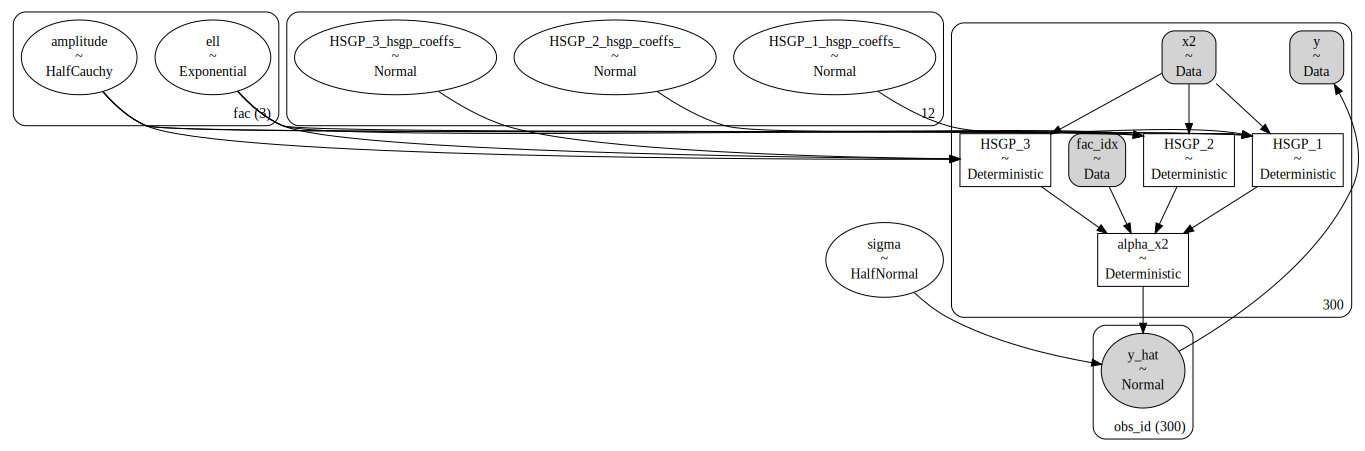

In [6]:
pm.model_to_graphviz(model)

In [ ]:
# Fit the model
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


# Plot results

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))

fac = '1'
sns.scatterplot(data=data.query(f"fac == {fac}"), x='x2', y='y',ax=ax, color='C0', size=1)
f = az.extract(trace, group="posterior", var_names=f"HSGP_{fac}")
idx = np.argsort(data['x2'].values)
ax.plot(data["x2"].values[idx], f.values[idx,:100], alpha=0.05, color="C0")
ax.plot(data["x2"].values[idx], f.values[idx].mean(1), color="C0", lw=2)

fac = '2'
sns.scatterplot(data=data.query(f"fac == {fac}"), x='x2', y='y',ax=ax, color='C1', size=1)
f = az.extract(trace, group="posterior", var_names=f"HSGP_{fac}")
idx = np.argsort(data['x2'].values)
ax.plot(data["x2"].values[idx], f.values[idx,:100], alpha=0.05, color="C1")
ax.plot(data["x2"].values[idx], f.values[idx].mean(1), color="C1", lw=2)

fac = '3'
sns.scatterplot(data=data.query(f"fac == {fac}"), x='x2', y='y',ax=ax, color='C2', size=1)
f = az.extract(trace, group="posterior", var_names=f"HSGP_{fac}")
idx = np.argsort(data['x2'].values)
ax.plot(data["x2"].values[idx], f.values[idx,:100], alpha=0.05, color="C2")
ax.plot(data["x2"].values[idx], f.values[idx].mean(1), color="C2", lw=2)

ax.legend('');